# Algorithmic Fairness, Accountability, and Ethics, Spring 2026

## Mandatory Assignment 1

Please use the following code to prepare the dataset.
 

In [ ]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']
 
target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()] 
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values    
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

### Features of original dataset
AGEP: Age

CIT: Citizenship status

COW: Class of worker

ENG: English proficiency

SCHL: Education level

MAR: Marital status

HINS1, HINS2, HINS4: Types of health insurance

RAC1P: Race

SEX: Gender

target_name = "PINCP": Person’s total income (continuous).

In [29]:
data_original

,AGEP,CIT,COW,ENG,SCHL,MAR,HINS1,HINS2,HINS4,RAC1P,SEX,target,PINCP
0,30,1,6.0,1.0,14.0,1,2,2,1,8,1,True,48500.0
6,21,1,4.0,NaN,16.0,5,2,1,2,1,1,False,7700.0
7,65,1,2.0,1.0,22.0,5,2,2,2,1,1,False,17200.0
10,33,1,1.0,1.0,14.0,3,2,2,1,1,1,False,12000.0
13,18,1,2.0,NaN,19.0,5,2,1,2,1,2,False,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,38,5,1.0,1.0,22.0,1,1,2,2,6,1,True,565280.0
378802,39,5,1.0,1.0,22.0,1,1,2,2,6,2,True,210000.0
378807,61,1,1.0,NaN,19.0,1,1,2,2,1,1,True,105000.0
378811,69,4,7.0,2.0,24.0,1,2,2,2,6,1,False,30000.0


## Preprocessing

 - This removes invalid or irrelevant rows:

 - Removes missing gender or race values.

 - Keeps only adults (AGEP > 16).

 - Removes very low income (< $100) and people with 0 work hours.

 - Keeps only rows with a valid person weight (PWGTP >= 1).
 
 - sex: Saves the SEX column for bias or fairness analysis later.

 - Converts the income (PINCP) into a binary target:

 - target = True if income > threshold ($35,000 by default), else False.

In [30]:
data

,AGEP,HINS1_2,HINS2_2,HINS4_2,CIT_2,CIT_3,CIT_4,CIT_5,COW_2.0,COW_3.0,...,RAC1P_4,RAC1P_5,RAC1P_6,RAC1P_7,RAC1P_8,RAC1P_9,ENG_2.0,ENG_3.0,ENG_4.0,ENG_nan
0,30,True,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
6,21,True,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
7,65,True,True,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
10,33,True,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
13,18,True,False,True,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378801,38,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378802,39,False,True,True,False,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,False
378807,61,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
378811,69,True,True,True,False,False,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False


# Task 1

## Train models logistic regression and random forest

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# 1. Feature Engineering: Scale features for Logistic Regression [cite: 13]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Train Logistic Regression (White-Box) 
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_preds = lr_model.predict(X_test_scaled)

# 3. Train Random Forest (Black-Box) 
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train) # RF is scale-invariant
rf_preds = rf_model.predict(X_test)

# 4. Report Accuracy [cite: 14]
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_preds):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_preds):.4f}")

Logistic Regression Accuracy: 0.7697
Random Forest Accuracy: 0.7460


## Compute Statistical Parity and Equalized Odds (T=1 and T=0)

In [32]:
import matplotlib.pyplot as plt

def compute_fairness_metrics(y_true, y_pred, groups):
    results = {}
    for g in np.unique(groups):
        print(g)
        mask = (groups == g)
        y_g = y_true[mask]
        pred_g = y_pred[mask]
        
        # Statistical Parity: P(Y_hat = 1 | G = g)
        sp = np.mean(pred_g)
        # TPR (Equalized Odds T=1): P(Y_hat = 1 | Y = 1, G = g)
        tpr = np.sum((pred_g == 1) & (y_g == 1)) / np.sum(y_g == 1)
        # FPR (Equalized Odds T=0): P(Y_hat = 1 | Y = 0, G = g)
        fpr = np.sum((pred_g == 1) & (y_g == 0)) / np.sum(y_g == 0)
        
        results[g] = [sp, tpr, fpr]
    return results

# Calculate metrics for both models
lr_metrics = compute_fairness_metrics(y_test, lr_preds, group_test)
rf_metrics = compute_fairness_metrics(y_test, rf_preds, group_test)

1
2
1
2


In [33]:
print(rf_metrics)
print(lr_metrics)

{np.int64(1): [np.float64(0.6243150186702876), np.float64(0.818254221089519), np.float64(0.32238065716057035)], np.int64(2): [np.float64(0.5034031979256698), np.float64(0.7345142479920783), np.float64(0.2804839223177332)]}
{np.int64(1): [np.float64(0.6418699384122981), np.float64(0.851784007645747), np.float64(0.31506509609423433)], np.int64(2): [np.float64(0.516961970613656), np.float64(0.7729123115854329), np.float64(0.270083837419081)]}


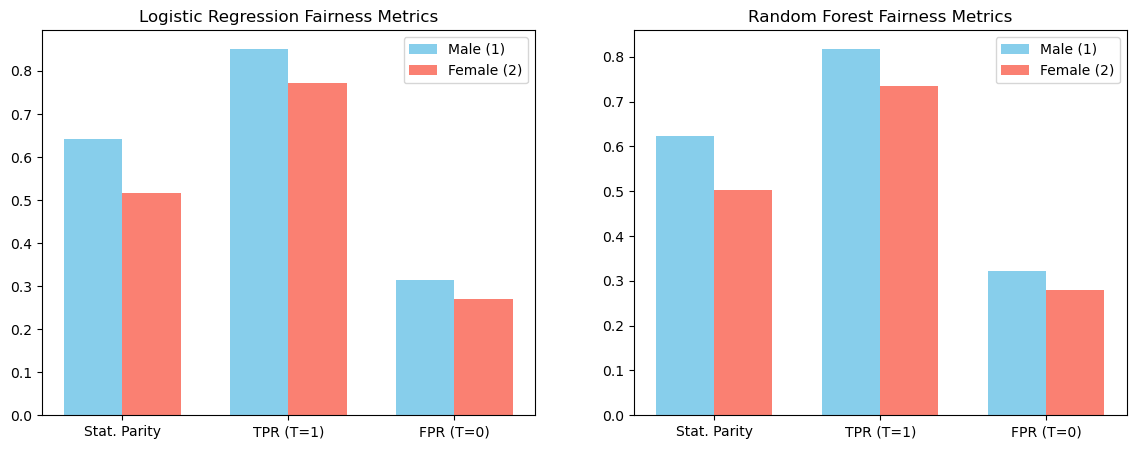

In [34]:
labels = ['Stat. Parity', 'TPR (T=1)', 'FPR (T=0)']
x = np.arange(len(labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Logistic Regression
ax1.bar(x - width/2, lr_metrics[1.0], width, label='Male (1)', color='skyblue')
ax1.bar(x + width/2, lr_metrics[2.0], width, label='Female (2)', color='salmon')
ax1.set_title('Logistic Regression Fairness Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# Plot Random Forest
ax2.bar(x - width/2, rf_metrics[1.0], width, label='Male (1)', color='skyblue')
ax2.bar(x + width/2, rf_metrics[2.0], width, label='Female (2)', color='salmon')
ax2.set_title('Random Forest Fairness Metrics')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.show()

## Post processing statistical parity

In [35]:
def post_process_statistical_parity(probs, groups, target_rate):
    """
    Adjusts thresholds per group to reach a target positive prediction rate.
    """
    adjusted_preds = np.zeros(len(probs))
    for g in np.unique(groups):
        group_mask = (groups == g)
        group_probs = probs[group_mask]
            
        # Determine the threshold required to meet the target rate for this group
        # (1 - target_rate) percentile gives the cutoff for the top X% 
        threshold = np.percentile(group_probs, 100 * (1 - target_rate))
        adjusted_preds[group_mask] = (group_probs >= threshold).astype(int)
    return adjusted_preds
# --- Logistic Regression Intervention (White-box) --- [cite: 12]

# 1. Get continuous probabilities 
lr_probs = lr_model.predict_proba(X_test_scaled)[:, 1]

# 2. Define a target positive rate (using original predictions to maintain similar volume)
global_target_rate_lr = np.mean(lr_preds)

# 3. Apply the post-processing intervention
fair_lr_preds = post_process_statistical_parity(lr_probs, group_test, global_target_rate_lr)

# 4. Re-calculate metrics for the report 
fair_lr_metrics = compute_fairness_metrics(y_test, fair_lr_preds, group_test)
fair_lr_acc = accuracy_score(y_test, fair_lr_preds)


# --- Random Forest Intervention (Black-box) --- [cite: 12]

# 1. Get probabilities (Note: RF usually uses unscaled X_test unless specified otherwise) 
rf_probs = rf_model.predict_proba(X_test)[:, 1] 

# 2. Use the average rate from the original RF model
global_target_rate_rf = np.mean(rf_preds)

# 3. Apply the intervention to the RF results
fair_rf_preds = post_process_statistical_parity(rf_probs, group_test, global_target_rate_rf)

# 4. Re-calculate metrics for the RF model 
fair_rf_metrics = compute_fairness_metrics(y_test, fair_rf_preds, group_test)
fair_rf_acc = accuracy_score(y_test, fair_rf_preds)

# --- Output Results --- 

print(f"Logistic Regression - Original Accuracy: {accuracy_score(y_test, lr_preds):.4f}")
print(f"Logistic Regression - Post-Intervention Accuracy: {fair_lr_acc:.4f}")
print("-" * 30)
print(f"Random Forest - Original Accuracy: {accuracy_score(y_test, rf_preds):.4f}")
print(f"Random Forest - Post-Intervention Accuracy: {fair_rf_acc:.4f}")

1
2
1
2
Logistic Regression - Original Accuracy: 0.7697
Logistic Regression - Post-Intervention Accuracy: 0.7639
------------------------------
Random Forest - Original Accuracy: 0.7460
Random Forest - Post-Intervention Accuracy: 0.7407


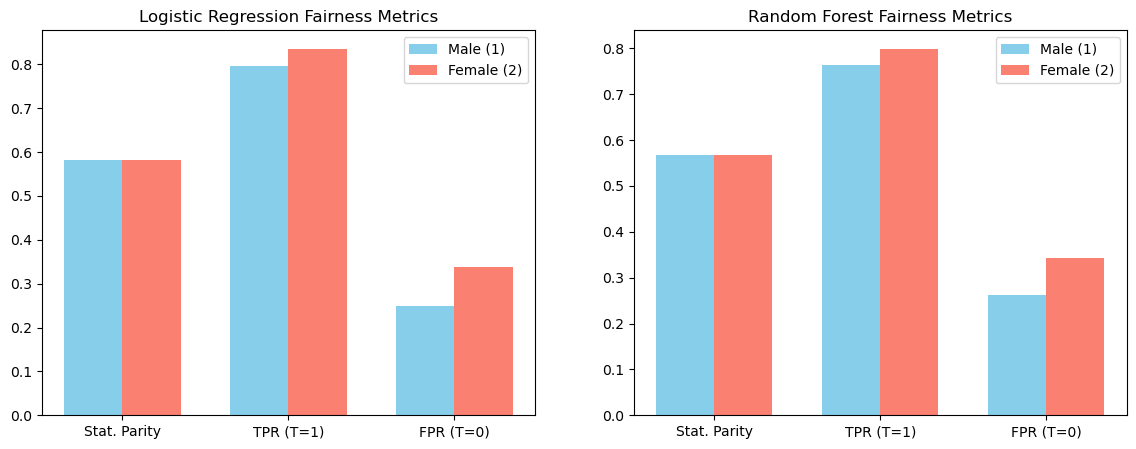

In [36]:
labels = ['Stat. Parity', 'TPR (T=1)', 'FPR (T=0)']
x = np.arange(len(labels))
width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Logistic Regression
ax1.bar(x - width/2, fair_lr_metrics[1.0], width, label='Male (1)', color='skyblue')
ax1.bar(x + width/2, fair_lr_metrics[2.0], width, label='Female (2)', color='salmon')
ax1.set_title('Logistic Regression Fairness Metrics')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

# Plot Random Forest
ax2.bar(x - width/2, fair_rf_metrics[1.0], width, label='Male (1)', color='skyblue')
ax2.bar(x + width/2, fair_rf_metrics[2.0], width, label='Female (2)', color='salmon')
ax2.set_title('Random Forest Fairness Metrics')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend()

plt.show()